# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import json
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
MY_SOL = True

def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

## Load Wikipedia dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('data/people_wiki.csv')
URI = wiki.URI
wiki.drop('URI', 1, inplace=True)
print(wiki.shape)
wiki.head()

(59071, 2)


,name,text
0,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [3]:
cntV = CountVectorizer(strip_accents=None, min_df=1)
cntV

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [4]:
wiki_count = cntV.fit_transform(wiki.text)
len(cntV.vocabulary_)

548429

In [5]:
word_count = wiki_count if MY_SOL else load_sparse_csr('data/people_wiki_word_count.npz') 
print(word_count.shape)

(59071, 548429)


In [6]:
if MY_SOL:
    map_index_to_word = cntV.vocabulary_
else:
    with open('data/people_wiki_map_index_to_word.json', 'r') as f:
        map_index_to_word = json.load(f)
print(len(map_index_to_word))

548429


In [7]:
def inv_dict(d):
    rd = {}
    for k, v in d.items():
        assert v not in rd
        rd[v] = k
    return rd
inv_map_index_to_word = inv_dict(map_index_to_word)
inv_map_index_to_word[5000]

'17492000'

## Extract word count vectors

As we have seen in Course 1, we can extract word count vectors using a GraphLab utility function.  We add this as a column in `wiki`.

## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.  For this, again will we use a GraphLab Create implementation of nearest neighbor search.

In [8]:
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

Let's look at the top 10 nearest neighbors by performing the following query:

In [9]:
obama = wiki[wiki['name'] == 'Barack Obama']
obama

,name,text
35817,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [10]:
distances, indices = model.kneighbors(word_count[obama.index], n_neighbors=10)

In [11]:
def unpack_dict(matrix, inv_map_index_to_word):
    table = inv_map_index_to_word
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr

    num_doc = matrix.shape[0]

    wd = []
    for i in range(num_doc):
        r = []
        for word_id in indices[indptr[i]:indptr[i+1]]:
            r.append(table[word_id])
        di = dict(zip(r, data[indptr[i]:indptr[i+1]].tolist()))
        wd.append(di)
    return wd

wiki['word_count'] = unpack_dict(word_count, inv_map_index_to_word)

In [12]:
x = wiki.loc[indices[0]].copy()
x['distance'] = distances[0]
x

,name,text,word_count,distance
35817,Barack Obama,barack hussein obama ii brk husen bm born augu...,"{'other': 1, 'with': 3, 'unconstitutional': 1,...",0.000000
24478,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,"{'military': 1, 'with': 3, 'liberties': 1, 'in...",33.015148
28447,George W. Bush,george walker bush born july 6 1946 is an amer...,"{'military': 1, 'with': 1, 'challenges': 1, 'b...",34.307434
14754,Mitt Romney,willard mitt romney born march 12 1947 is an a...,"{'with': 1, 'provided': 1, 'several': 1, 'losi...",35.791060
35357,Lawrence Summers,lawrence henry larry summers born november 30 ...,"{'with': 2, 'goldman': 1, 'professor': 2, 'whi...",36.069378
31423,Walter Mondale,walter frederick fritz mondale born january 5 ...,"{'with': 3, 'old': 1, 'graduated': 1, 'however...",36.249138
13229,Francisco Barrio,francisco javier barrio terrazas born november...,"{'with': 1, 'ambassador': 1, 'vicente': 1, 'un...",36.276714
36364,Don Bonker,don leroy bonker born march 7 1937 in denver c...,"{'1988': 2, 'neuberger': 1, 'losing': 1, 'bonk...",36.400549
22745,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...,"{'other': 1, 'with': 3, 'role': 1, 'then': 1, ...",36.441734
7660,Refael (Rafi) Benvenisti,refael rafi benvenisti hebrew born in 1937 was...,"{'with': 1, 'old': 1, 'authority': 1, 'meron':...",36.837481


All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama.  To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages:

In [13]:
def top_words(name, col='word_count'):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame(row[col].values.tolist()).T.rename(columns={0:col})
    return word_count_table.sort_values(by=col, ascending=False)

In [14]:
obama_words = top_words('Barack Obama')
barrio_words = top_words('Francisco Barrio')
combined_words = obama_words.merge(barrio_words, left_index=True, right_index=True, suffixes=['_obama', '_barrio'])
combined_words.sort_values(by='word_count_obama', ascending=False, inplace=True)
combined_words

,word_count_obama,word_count_barrio
the,40,36
in,30,17
and,21,18
of,18,24
to,14,9
his,11,5
he,7,10
as,6,5
was,5,4
for,4,3


**Quiz Question**. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

Hint:
* Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five.
* Each word count vector is a Python dictionary. For each word count vector in SFrame, you'd have to check if the set of the 5 common words is a subset of the keys of the word count vector. Complete the function `has_top_words` to accomplish the task.
  - Convert the list of top 5 words into set using the syntax
```
set(common_words)
```
    where `common_words` is a Python list. See [this link](https://docs.python.org/2/library/stdtypes.html#set) if you're curious about Python sets.
  - Extract the list of keys of the word count dictionary by calling the [`keys()` method](https://docs.python.org/2/library/stdtypes.html#dict.keys).
  - Convert the list of keys into a set as well.
  - Use [`issubset()` method](https://docs.python.org/2/library/stdtypes.html#set) to check if all 5 words are among the keys.
* Now apply the `has_top_words` function on every row of the SFrame.
* Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

# Answer 1

In [15]:
common_words = set(combined_words.head(5).index.tolist())
print(common_words)
def has_top_words(vector, common_words):
    unique_words = set(vector.keys()) 
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(lambda x: has_top_words(x, common_words))

wiki['has_top_words'].mean(), wiki['has_top_words'].sum()

{'the', 'to', 'and', 'in', 'of'}


(0.9491290142371045, 56066)

In [16]:
wiki.drop(['has_top_words'], 1, inplace=True)

**Checkpoint**. Check your `has_top_words` function on two random articles:

In [17]:
print('Output from your function:', has_top_words(wiki.loc[32]['word_count'], common_words))
print('Correct output: True')
print('Also check the length of unique_words. It should be 167')
len(set(wiki.loc[32, 'word_count'].keys()))

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167


165

In [18]:
print('Output from your function:', has_top_words(wiki.iloc[33]['word_count'], common_words))
print('Correct output: False')
print('Also check the length of unique_words. It should be 188')
len(set(wiki.loc[33, 'word_count'].keys()))

Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188


182

**Quiz Question**. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

Hint: To compute the Euclidean distance between two dictionaries, use `graphlab.toolkits.distances.euclidean`. Refer to [this link](https://dato.com/products/create/docs/generated/graphlab.toolkits.distances.euclidean.html) for usage.

In [19]:
def euclidean_dict(d1, d2):
    d = {k:0 for k in d1.keys()}
    d.update({k:0 for k in d2.keys()})
    ds = 0
    v1, v2 = np.zeros(len(d)), np.zeros(len(d))
    for i, w in enumerate(d.keys()):
        ds += ((d1.get(w, 0) - d2.get(w, 0))**2)
        v1[i] = d1.get(w, 0)
        v2[i] = d2.get(w, 0)
    return np.sqrt(ds)

# Answer

In [20]:
names = ('Barack Obama', 'George W. Bush', 'Joe Biden')
idxs = wiki[wiki.name.isin(names)].index.values
distances = []
for i in range(len(idxs)):
    for j in range(i+1, len(idxs)):
        idx_i, idx_j = idxs[i], idxs[j]
        v1 = word_count[idx_i].toarray()
        v2 = word_count[idx_j].toarray()
        dist = euclidean(v1, v2)
        dist2 = euclidean_dict(wiki.loc[idx_i, 'word_count'], wiki.loc[idx_j, 'word_count'])
        distances.append((dist2, dist, (wiki.loc[idx_i, 'name'], wiki.loc[idx_j, 'name'])))
pd.DataFrame(distances, columns=["edict", "e", "pair"]).sort_values(by="edict")

,edict,e,pair
0,32.695565,32.695565,"(Joe Biden, George W. Bush)"
1,33.015148,33.015148,"(Joe Biden, Barack Obama)"
2,34.307434,34.307434,"(George W. Bush, Barack Obama)"


**Quiz Question**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

# Answer

In [21]:
obama_words = top_words('Barack Obama')
bush_words = top_words('George W. Bush')
combined_words = obama_words.merge(bush_words, left_index=True, right_index=True, suffixes=['_obama', '_bush'])
combined_words.sort_values(by='word_count_obama', ascending=False, inplace=True)
combined_words

,word_count_obama,word_count_bush
the,40,39
in,30,22
and,21,14
of,18,14
to,14,11
his,11,6
act,8,3
he,7,8
as,6,6
law,6,1


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

# TODO

## TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.  Let's use GraphLab Create's implementation of TF-IDF and repeat the search for the 10 nearest neighbors of Barack Obama:

In [22]:
tfidfV = TfidfVectorizer(strip_accents=None, min_df=1, smooth_idf=True, sublinear_tf=False, norm='l2')
tfidfV

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [23]:
tf_idf = tfidfV.fit_transform(wiki.text)
print(tf_idf.shape, len(tfidfV.vocabulary_))

(59071, 548429) 548429


In [24]:
tf_idf = tf_idf if MY_SOL else load_sparse_csr('data/people_wiki_tf_idf.npz')
wiki['tf_idf'] = unpack_dict(tf_idf, inv_map_index_to_word)

In [25]:
wiki.head()

,name,text,word_count,tf_idf
0,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'the': 27, 'with': 5, 'footballer': 1, 'cause...","{'game': 0.03453190805203886, 'other': 0.02468..."
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'the': 2, 'with': 2, 'jet': 1, 'monitored': 1...","{'the': 0.01779969459071123, 'their': 0.022426..."
2,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'the': 12, 'with': 4, 'release': 1, 'their': ...","{'broadcaster': 0.06497209837854676, 'their': ..."
3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'with': 3, 'yet': 1, 'however': 1, 'banal': 1...","{'with': 0.028519351484215635, 'just': 0.02925..."
4,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'the': 8, 'with': 2, 'warmup': 1, 'tag': 4, '...","{'performers': 0.04879256902747712, 'their': 0..."


In [26]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [27]:
distances, indices = model_tf_idf.kneighbors(tf_idf[obama.index], n_neighbors=5000)
x = wiki.loc[indices[0]].copy().reset_index(drop=True)
x['distance'] = distances[0]
x[['name', 'distance']].iloc[1:30].style.bar(subset='distance')

In [28]:
names = ['Phil Schiliro', 'Jesse Lee (politician)', 'Samantha Power', 'Eric Stern (politician)', 'Joe Biden',
         'Roland Grossenbacher', 'Tulsi Gabbard', 'James A. Guest', 'Bob Menendez', 'Jeff Sessions']
print(len(names))
x[x.name.isin(names)][['name', 'distance']]

10


,name,distance
1,Joe Biden,1.068439
3,Samantha Power,1.118028
4,Eric Stern (politician),1.139969
9,Jeff Sessions,1.159678
26,Jesse Lee (politician),1.182870
28,Phil Schiliro,1.184422
51,Bob Menendez,1.198587
64,Tulsi Gabbard,1.203034
406,James A. Guest,1.235603
1192,Roland Grossenbacher,1.253939


Let's determine whether this list makes sense.
* With a notable exception of Roland Grossenbacher, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Schiliro's article as well.

In [29]:
obama_tf_idf = top_words('Barack Obama', col='tf_idf')
schiliro_tf_idf = top_words('Phil Schiliro', col='tf_idf')
combined_tf_idf = obama_tf_idf.merge(schiliro_tf_idf, left_index=True, right_index=True, suffixes=['_obama', '_phil'])
combined_tf_idf.sort_values(by='tf_idf_obama', ascending=False, inplace=True)
combined_tf_idf.head(12)

,tf_idf_obama,tf_idf_phil
obama,0.365018,0.169897
the,0.279323,0.146262
in,0.209673,0.073194
and,0.146739,0.087813
law,0.144687,0.151525
of,0.126205,0.132169
democratic,0.114575,0.119990
to,0.102342,0.107179
his,0.096976,0.018465
senate,0.091908,0.064167


The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

**Quiz Question**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

# Answer 2

In [30]:
common_words = set(combined_tf_idf.head(5).index.tolist())
print(common_words)
wiki['has_top_words'] = wiki['word_count'].apply(lambda x: has_top_words(x, common_words))

print(wiki['has_top_words'].mean().round(5), wiki['has_top_words'].sum())

{'the', 'obama', 'law', 'and', 'in'}
0.00232 137


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of `model_tf_idf`. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden. Hint: When using Boolean filter in SFrame/SArray, take the index 0 to access the first match.

In [31]:
binden = wiki[wiki.name=='Joe Biden']
obama = wiki[wiki.name=='Barack Obama']

euclidean_dict(obama.tf_idf.values[0], binden.tf_idf.values[0])

1.0684387489755511

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [32]:
distances, indices = model_tf_idf.kneighbors(tf_idf[obama.index], n_neighbors=5000)
x = wiki.loc[indices[0]].copy().reset_index(drop=True)
x['distance'] = distances[0]
x[['name', 'distance']].iloc[1:10].style.bar(subset='distance')

But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [33]:
wiki['length'] = wiki.text.apply(lambda x: len(x.split(' '))) 
distances, indices = model_tf_idf.kneighbors(tf_idf[obama.index], n_neighbors=100)
x = wiki.loc[indices[0]].copy().reset_index(drop=True)
x['distance'] = distances[0]
nearest_neighbors_euclidean = x[['name', 'distance', 'length']]
nearest_neighbors_euclidean.iloc[1:30].style.bar(subset=['length', 'distance'])

To see how these document lengths compare to the lengths of other documents in the corpus, let's make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

In [34]:
wiki['length'].describe()

count    59071.000000
mean       314.776506
std        134.577685
min        201.000000
25%        231.000000
50%        275.000000
75%        352.000000
max       5351.000000
Name: length, dtype: float64

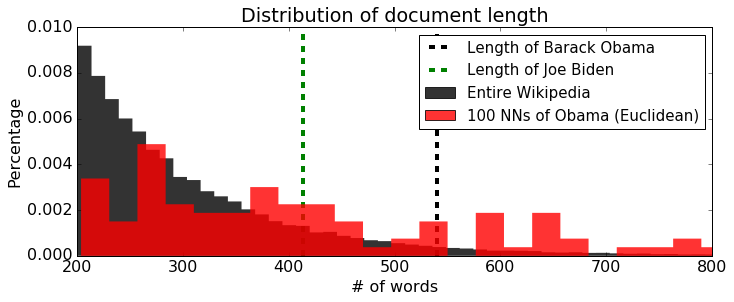

In [35]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], bins=400, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], bins=50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)

plt.axvline(x=wiki[wiki['name'] == 'Barack Obama']['length'].values[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki[wiki['name'] == 'Joe Biden']['length'].values[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([200, 800, 0,  0.01 if  MY_SOL else  0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 2000 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many Wikipedia articles are 2500 words or more, and both Obama and Biden are over 2500 words long. 

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [36]:
model2_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model2_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [37]:
wiki['length'] = wiki.text.apply(lambda x: len(x.split(' '))) 
distances, indices = model2_tf_idf.kneighbors(tf_idf[obama.index], n_neighbors=100)
x = wiki.loc[indices[0]].copy().reset_index(drop=True)
x['distance'] = distances[0]
nearest_neighbors_cosine = x[['name', 'distance', 'length']]
nearest_neighbors_cosine.iloc[1:30].style.bar(subset=['length', 'distance'])

In [38]:
nearest_neighbors_cosine.reset_index().merge(nearest_neighbors_euclidean.reset_index(), on='name', suffixes=['_cosine', '_euclidean']).round(4)

,index_cosine,name,distance_cosine,length_cosine,index_euclidean,distance_euclidean,length_euclidean
0,0,Barack Obama,-0.0000,540,0,0.0000,540
1,1,Joe Biden,0.5708,414,1,1.0684,414
2,2,Hillary Rodham Clinton,0.6159,580,2,1.1099,580
3,3,Samantha Power,0.6250,310,3,1.1180,310
4,4,Eric Stern (politician),0.6498,255,4,1.1400,255
5,5,George W. Bush,0.6587,505,5,1.1478,505
6,6,John McCain,0.6617,410,6,1.1504,410
7,7,Artur Davis,0.6669,371,7,1.1549,371
8,8,Henry Waxman,0.6702,279,8,1.1578,279
9,9,Jeff Sessions,0.6724,230,9,1.1597,230


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

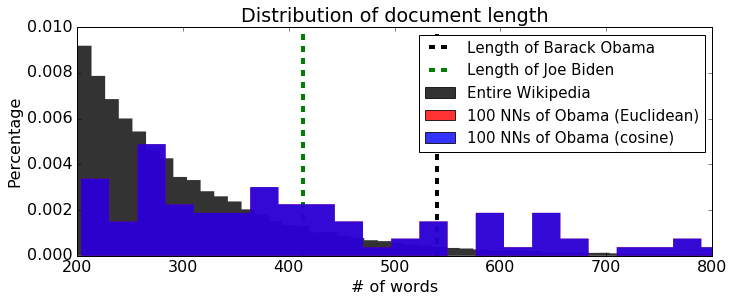

In [39]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], bins=400, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], bins=50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki[wiki['name'] == 'Barack Obama']['length'].values[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki[wiki['name'] == 'Joe Biden']['length'].values[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([200, 800, 0, 0.01 if MY_SOL else 0.040])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

# Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [40]:
sf = pd.Series({'text': ['democratic governments control law in response to popular act']})
sf['word_count'] = unpack_dict(cntV.transform(sf.text), inv_dict(cntV.vocabulary_))
sf['tf_idf'] = unpack_dict(tfidfV.transform(sf.text), inv_dict(tfidfV.vocabulary_))
sf

text          [democratic governments control law in respons...
word_count    [{'law': 1, 'democratic': 1, 'popular': 1, 'co...
tf_idf        [{'act': 0.37479247811583105, 'democratic': 0....
dtype: object

In [41]:
tweet_tf_idf = sf['tf_idf'][0]
tweet_tf_idf

{'act': 0.37479247811583105,
 'control': 0.3967984988758505,
 'democratic': 0.34479197585399796,
 'governments': 0.43423469036836093,
 'in': 0.0841293402983463,
 'law': 0.2902724514018284,
 'popular': 0.3163765280337304,
 'response': 0.44211697963594787,
 'to': 0.08799377017779698}

In [42]:
if not MY_SOL:
    tweet = {'act': 3.4597778278724887,
     'control': 3.721765211295327,
     'democratic': 3.1026721743330414,
     'governments': 4.167571323949673,
     'in': 0.0009654063501214492,
     'law': 2.4538226269605703,
     'popular': 2.764478952022998,
     'response': 4.261461747058352,
     'to': 0.04694493768179923}
    tweet_tf_idf = tweet

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [43]:
tweet_tf_idf

{'act': 0.37479247811583105,
 'control': 0.3967984988758505,
 'democratic': 0.34479197585399796,
 'governments': 0.43423469036836093,
 'in': 0.0841293402983463,
 'law': 0.2902724514018284,
 'popular': 0.3163765280337304,
 'response': 0.44211697963594787,
 'to': 0.08799377017779698}

In [44]:
def cosine_dict(d1, d2):
    keys = set(d1.keys()).intersection(d2.keys())
    norm = lambda d: np.sqrt(np.sum((x**2 for x in d.values())))
    n1, n2 = norm(d1), norm(d2)
    ds = 0
    for i, w in enumerate(keys):
        ds += (d1[w]*d2[w])
    ds = ds/(n1*n2)
    return 1-round(ds, 8)
d1, d2 = tweet_tf_idf, tweet_tf_idf
print(round(cosine_dict(d1, d2), 5))

0.0


Now, compute the cosine distance between the Barack Obama article and this tweet:

In [45]:
obama_tf_idf = obama['tf_idf'].values[0]
cosine_dict(obama_tf_idf, tweet_tf_idf), euclidean_dict(obama_tf_idf, tweet_tf_idf)

(0.69745829999999998, 1.1810658727114214)

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors:

In [46]:
nearest_neighbors_euclidean.iloc[1:10].style.bar(subset=['length', 'distance'])

In [47]:

nearest_neighbors_cosine.iloc[1:10].style.bar(subset=['length', 'distance'])

With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden!  This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.